In [1]:
# filename: daily_sentiment_analysis.ipynb
# author: Xingyu Pan
# date: 2023.12.8

# What this code file does:
# Predicting US economic indicators based on daily sentiment scores of Bloomberg news text using traditional machine-learning and deep-learning models
# main steps:
# 1. data preparation: processing missing values, calculating statistics, constructing training and test sets
# 2. Model selection and design: linear regression, decision tree, random forest, NN, CNN, LSTM.
# 3. Model training and optimization: designing model structure (NN and CNN), tuning model hyperparameters (all), trying different training methods
# 4. Performance testing: leave-out validation, timing cross-validation

In [2]:
import tensorflow as tf # keras = 2.15.0
import pandas as pd # 2.1.3
import numpy as np # 1.26.2
import matplotlib.pyplot as plt # 3.8.2
from sklearn.preprocessing import MinMaxScaler,StandardScaler # 1.3.2
import ast # python = 3.10.0

In [3]:
def datetime2index(data,time_clo):
    # Converts dates to a 'datetime' class and sets it as an index
    data[time_clo] = pd.to_datetime(data[time_clo])
    data.set_index(time_clo, inplace=True)
    try:
        data = data.drop("Unnamed: 0",axis=1) # drop unnamed column
    except:
        return data
    return data

In [4]:
# load datas
datas_distilbert = pd.read_csv('./datas_distilbert.csv')
datas_FinBERT = pd.read_csv('./datas_FinBERT.csv')
datas_twitter = pd.read_csv('./datas_twitter_roberta.csv')
datas_finbert_tone = pd.read_csv('./datas_finbert_tone.csv')
print("len of distilbert   1:",len(datas_distilbert))
print("len of FinBERT      2:",len(datas_FinBERT))
print("len of twitter      3:",len(datas_twitter))
print("len of finbert_tone 4:",len(datas_finbert_tone))
print("When merging data, please select the data with the smallest length to merge.")
# Load labels
monthly_labels = pd.read_csv("./monthly_merged_label.csv")
quarterly_labels = pd.read_csv("./Quarterly_merged_label.csv")

# Converts dates to a 'datetime' class and sets it as an index
datas_distilbert = datetime2index(datas_distilbert,'times')
datas_FinBERT = datetime2index(datas_FinBERT,'times')
datas_twitter = datetime2index(datas_twitter,'times')
datas_finbert_tone = datetime2index(datas_finbert_tone,'times')

# two kinds of labels
monthly_labels = datetime2index(monthly_labels,'observation_date')
quarterly_labels = datetime2index(quarterly_labels,'observation_date')

len of distilbert   1: 1944
len of FinBERT      2: 1944
len of twitter      3: 1944
len of finbert_tone 4: 1944
When merging data, please select the data with the smallest length to merge.


In [5]:
# Add suffixes to columns to avoid conflicts when merging
datas_twitter = datas_twitter.add_suffix('_1')
datas_distilbert = datas_distilbert.add_suffix('_2')
datas_FinBERT = datas_FinBERT.add_suffix('_3')
datas_finbert_tone = datas_finbert_tone.add_suffix('_4')

In [6]:
# Select the data merge with the smallest length, which is currently：FinBERT
data = datas_twitter.join([datas_distilbert,datas_FinBERT,datas_finbert_tone],how='left')
print('len of datas:',len(data))
missing_values_per_column = data.isna().sum()
print(missing_values_per_column)
# In order for the following to be parsed correctly as a list, this needs to be populated with '[0]'
data.fillna("[0]", inplace=True) 

len of datas: 1944
sentiment_scores_1    0
sentiment_scores_2    0
sentiment_scores_3    0
sentiment_scores_4    0
dtype: int64


In [7]:
# Remove zeros from the list and compute the statistic
'''
@calculate_statistics
lst:An iterable object such as a List/Series
'''
def calculate_statistics(lst):
    # Remove 0 from the list
    cleaned_list = [x for x in lst if x != 0]
    # If the cleaned list is not empty, calculate the statistic
    if cleaned_list:
        mean = np.mean(cleaned_list)
        std = np.std(cleaned_list)
    else:
        # If the cleaned list is empty
        mean = np.nan
        std = np.nan
    return mean, std

# Applying functions to each statistical column
for col in ['sentiment_scores_1', 'sentiment_scores_2', 'sentiment_scores_3', 'sentiment_scores_4']:
    # Parsing as a list
    data[col] = data[col].apply(ast.literal_eval)
    # Split the results into two new columns
    data[f'{col}_mean'], data[f'{col}_std'] = zip(*data[col].apply(calculate_statistics))

# check the results
data.head()

,sentiment_scores_1,sentiment_scores_2,sentiment_scores_3,sentiment_scores_4,sentiment_scores_1_mean,sentiment_scores_1_std,sentiment_scores_2_mean,sentiment_scores_2_std,sentiment_scores_3_mean,sentiment_scores_3_std,sentiment_scores_4_mean,sentiment_scores_4_std
times,,,,,,,,,,,,
2013-11-01,"[0.0, 0.0, -0.07065750945307601, 0.0, 0.0, 0.0...","[-0.105269950985069, 0.04868544997840092, -0.9...","[0.0, 0.0, -0.4034398047773688, 0.0, 0.7825204...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.005271,0.261425,-0.766551,0.493773,-0.415350,0.548216,NaN,NaN
2013-11-02,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.9550550448840067, -0.8589299462304008, -0....","[-0.21485524504152062, 0.0, -0.847485737464366...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.002305,0.336502,-0.463445,0.769622,-0.622405,0.311195,NaN,NaN
2013-11-03,"[0.0, 0.2950759232735689, 0.0, 0.0, 0.0, 0.0, ...","[-0.9973243400454521, -0.988380157615635, 0.51...","[-0.7329487577080727, -0.9065307146435271, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.077621,0.290665,-0.550872,0.681333,-0.335944,0.471607,NaN,NaN
2013-11-04,"[0.0, 0.32762563221586605, 0.0, 0.0, -0.136559...","[-0.9849116691521236, -0.9952108855101469, -0....","[0.0, -0.8968922550602431, 0.0, 0.0, -0.493128...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.030472,0.224971,-0.715305,0.523592,-0.391538,0.544814,NaN,NaN
2013-11-05,"[0.0, 0.3910888214500583, 0.0, 0.0, 0.0, 0.0, ...","[-0.965668657202695, -0.9541987272617227, -0.5...","[0.0, 0.38701758687458343, 0.0, 0.912935078144...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.011567,0.232591,-0.674599,0.575050,-0.369750,0.592652,NaN,NaN


In [8]:
data.to_csv('./datas.csv')

In [113]:
# Completion of missing dates

# 1. Create a DataFrame with all the dates.
all_dates = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
all_dates_df = pd.DataFrame(index=all_dates)

# 2. Merging data
data = all_dates_df.join(data, how='left')
missing_values_per_column = data.isna().sum()
print('len of data:',len(data),'\nmissing values:\n',missing_values_per_column)

len of data: 2595 
missing values:
 sentiment_scores_1          651
sentiment_scores_2          651
sentiment_scores_3          651
sentiment_scores_4          651
sentiment_scores_1_mean    1226
sentiment_scores_1_std     1226
sentiment_scores_2_mean     674
sentiment_scores_2_std      674
sentiment_scores_3_mean     828
sentiment_scores_3_std      828
sentiment_scores_4_mean    1413
sentiment_scores_4_std     1413
dtype: int64


In [114]:
# Completion of statistics for missing dates with 0
data = data.fillna(0)
# the input feature columns
print(data.columns[4:])

Index(['sentiment_scores_1_mean', 'sentiment_scores_1_std',
       'sentiment_scores_2_mean', 'sentiment_scores_2_std',
       'sentiment_scores_3_mean', 'sentiment_scores_3_std',
       'sentiment_scores_4_mean', 'sentiment_scores_4_std'],
      dtype='object')


In [115]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Prepare the inputs
input_data = []
for month, group in data.groupby(pd.Grouper(freq='M')): # M：Month；Q：Quarter
    # monthly_feature = group[['mean', 'median', 'max', 'min', 'std', 'rolling_mean', 'rolling_std', 'change_rate']].values
    monthly_feature = group[data.columns[4:]].values
    input_data.append(monthly_feature)

# Use pad_sequences for padding to ensure that the data is the same length for each month/quarter
input_data_padded = pad_sequences(input_data, padding='post', dtype='float32')
# Checking the shape of the filled data
print(input_data_padded.shape)

(86, 31, 8)


In [116]:
# # Feature normalisation, selecting columns to be normalised
# # columns_to_scale = data.columns[4:]
# # Initialising the standardiser
# scaler = MinMaxScaler()
# # Apply standardisation to selected columns
# data = scaler.fit_transform(data)
# data.head()

In [117]:
from pandas.tseries.offsets import MonthEnd
from pandas.tseries.offsets import QuarterEnd
#  Define the time range
start_date = data.index.min() # Start time
month_end_date = data.index.max()  + MonthEnd(2) # End time; plus 1 for prediction
quarter_end_date = data.index.max()  + QuarterEnd(1)
print(start_date,month_end_date,quarter_end_date)
# Filter labels corresponding to the time range
monthly_labels = monthly_labels.loc[start_date:month_end_date]
quarterly_labels = quarterly_labels.loc[start_date:quarter_end_date]

2006-10-20 00:00:00 2013-12-31 00:00:00 2013-12-31 00:00:00


In [118]:
# check the labels
print(monthly_labels.tail())
print(quarterly_labels.tail())

                    PAYEMS    CE16OV    INDPRO      CMRMT   PCEC96  W875RX1
observation_date                                                           
2013-08-01        136635.0  144326.0   99.5059  1249320.0  11890.3  12176.8
2013-09-01        136819.0  144418.0  100.0391  1253661.0  11926.1  12235.2
2013-10-01        137039.0  143537.0   99.9203  1260475.0  11964.6  12189.0
2013-11-01        137314.0  144479.0  100.1661  1275801.0  12013.7  12228.0
2013-12-01        137368.0  144778.0  100.3777  1270949.0  12024.7  12256.4
                  LB0000091Q020SBEA  A261RX1Q020SBEA      GDPC1  \
observation_date                                                  
2012-10-01                17610.359        17730.866  17489.852   
2013-01-01                17695.965        17729.530  17662.400   
2013-04-01                17773.235        17836.798  17709.671   
2013-07-01                17856.842        17853.234  17860.450   
2013-10-01                17986.093        17956.040  18016.147   

In [119]:
# Initialising a MinMaxScater
scaler = MinMaxScaler()
# **** select the predicted label **** #
label = monthly_labels['INDPRO'] # 85
# label = quarterly_labels['A261RX1Q020SBEA'] # 28
label_scaled = scaler.fit_transform(label.values.reshape(-1, 1))
print(label_scaled.shape)


(86, 1)


In [120]:
def plot_model(model,model_name,X,y,scaler = None):
    # Use a model for prediction, nn_model, rf_model, lr_model
    predicted = model.predict(X)
    # Converting predictions into one-dimensional arrays for easy plotting
    predicted = predicted.ravel()
    if scaler!=None:
        # Use an inverse transformation to bring it back to its original scale
        predicted = scaler.inverse_transform(predicted.reshape(-1, 1))
        y = scaler.inverse_transform(y)
    # Plotting true and predicted values
    plt.figure(figsize=(10,6))
    plt.plot(y, label='Actual',marker='o', linestyle='-')
    plt.plot(predicted, label='Predicted', marker='x', linestyle='-')
    plt.title(f"{model_name} Prediction vs Actual")
    plt.xlabel("Observations")
    plt.ylabel("Target")
    plt.legend()
    plt.show()

def plt_history(history):
    # Plotting training loss and validation loss
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Training Curve')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    return mse, rmse, r2

In [124]:
# The datas and labels for model training
X = input_data_padded # for monthly datas, some labels lack the last month
# X = input_data_padded[:28] # for quarterly labels : 缺少一个最新季度的标签所以不得不去掉最后一个月的特征
y = label_scaled

# Leave out the validation and divide the training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:] 
y_train, y_test = y[:train_size], y[train_size:]

In [125]:
# traditional models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Flatten data
X_train = X_train.reshape(X_train.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)

In [126]:
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(68, 248) (18, 248)
(68, 1) (18, 1)


Linear Regression - MSE: 0.1935, RMSE: 0.4399, R2: -62.2916


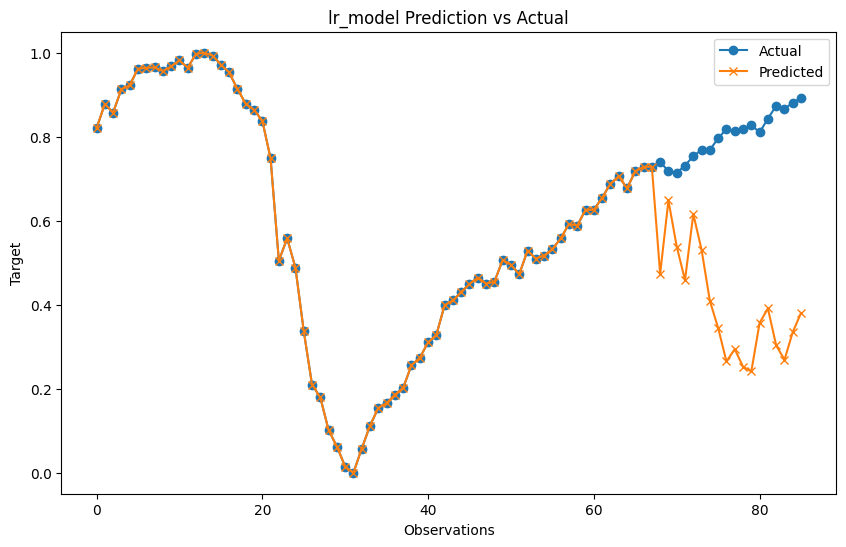

In [127]:
# linear regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
# Linear regression model evaluation
lr_mse, lr_rmse, lr_r2 = evaluate_model(lr_model, X_test, y_test)
print("Linear Regression - MSE: {:.4f}, RMSE: {:.4f}, R2: {:.4f}".format(lr_mse, lr_rmse, lr_r2))
plot_model(lr_model,'lr_model',X.reshape(X.shape[0],-1),y)

c:\Users\15163\.conda\envs\FDH\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest - MSE: 0.0550, RMSE: 0.2346, R2: -17.0040


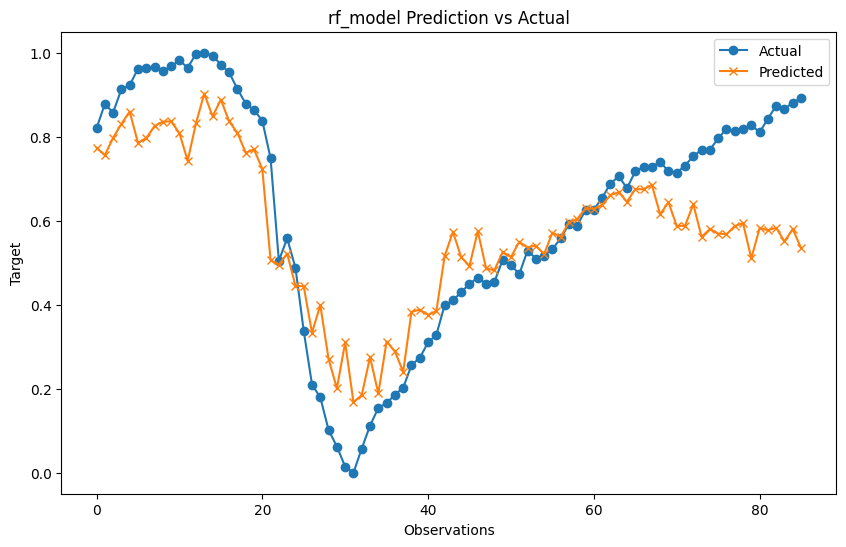

c:\Users\15163\.conda\envs\FDH\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest - MSE: 0.0482, RMSE: 0.2195, R2: -14.7562


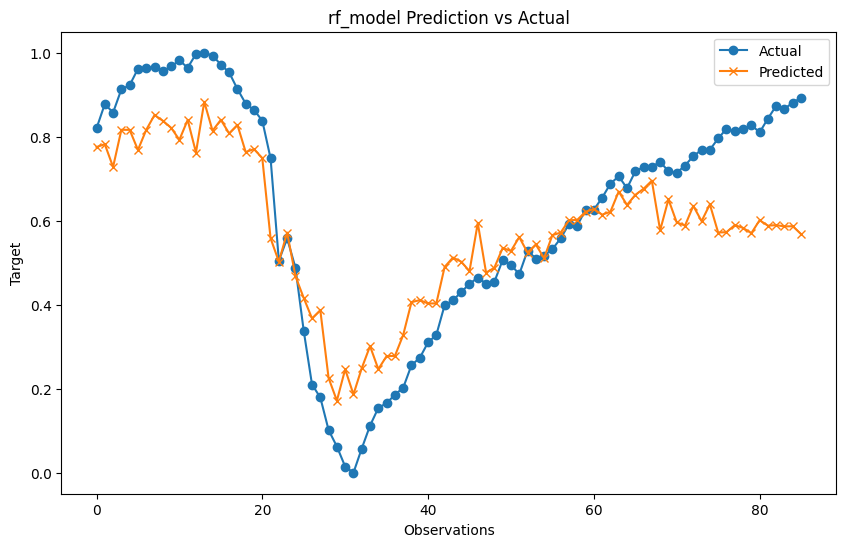

c:\Users\15163\.conda\envs\FDH\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest - MSE: 0.0465, RMSE: 0.2156, R2: -14.1984


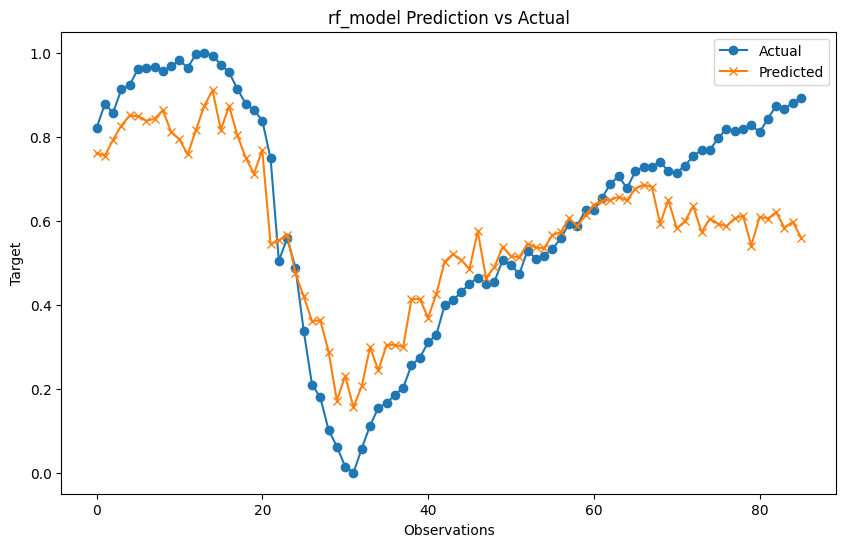

c:\Users\15163\.conda\envs\FDH\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest - MSE: 0.0549, RMSE: 0.2343, R2: -16.9590


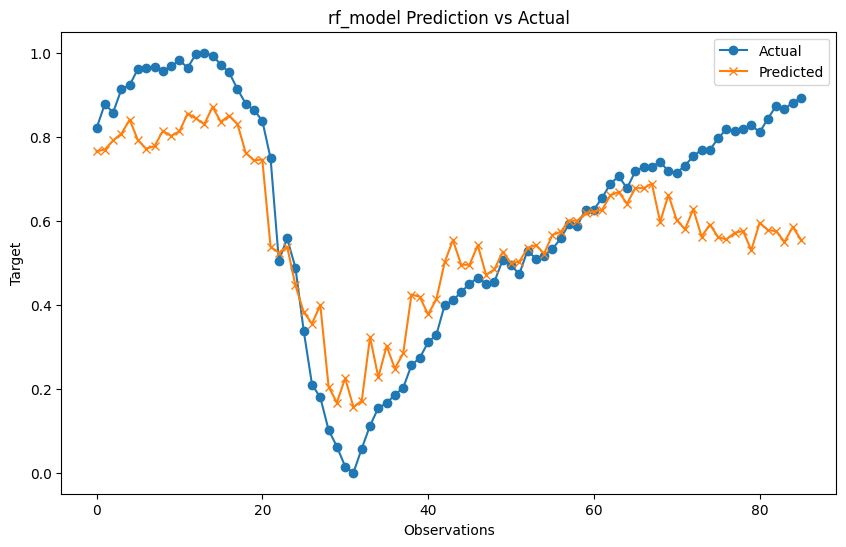

c:\Users\15163\.conda\envs\FDH\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest - MSE: 0.0524, RMSE: 0.2289, R2: -16.1339


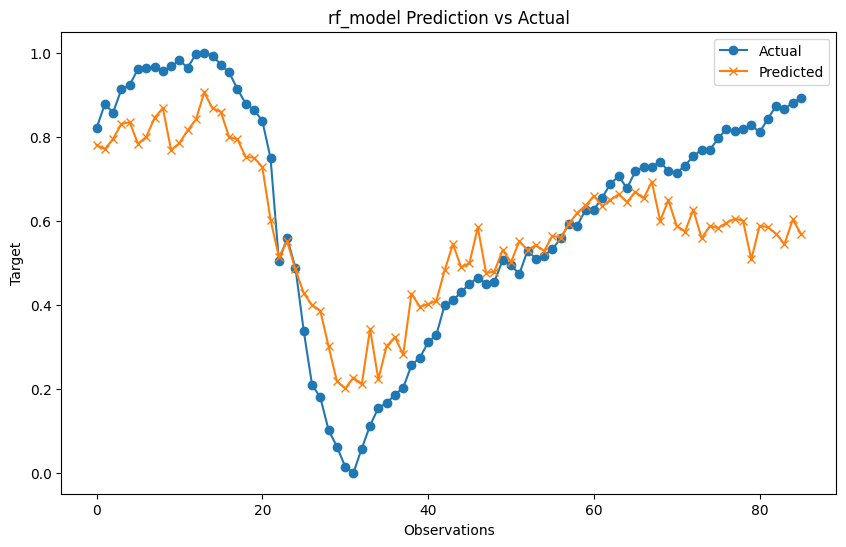

In [128]:
randoms = [42,409,523,218,404] # For Repeat Experiment
for random in randoms:
    # random forest
    rf_model = RandomForestRegressor(max_depth=10,random_state=random)
    rf_model.fit(X_train, y_train)
    # Random Forest Model Evaluation
    rf_mse, rf_rmse, rf_r2 = evaluate_model(rf_model, X_test, y_test)
    print("Random Forest - MSE: {:.4f}, RMSE: {:.4f}, R2: {:.4f}".format(rf_mse, rf_rmse, rf_r2))
    plot_model(rf_model,'rf_model',X.reshape(X.shape[0],-1),y)
    y_pred = rf_model.predict(X.reshape(X.shape[0],-1))
    # mse = mean_squared_error(y, y_pred)
    # print(f"Mean Squared Error: {mse}")


In [129]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Masking, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split,TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

Epoch 1/20
5/5 [==============================] - 1s 64ms/step - loss: 0.1788 - val_loss: 0.1803
Epoch 2/20
5/5 [==============================] - 0s 12ms/step - loss: 0.1257 - val_loss: 0.1060
Epoch 3/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0594 - val_loss: 0.0159
Epoch 4/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0442 - val_loss: 0.0224
Epoch 5/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0273 - val_loss: 0.0806
Epoch 6/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0223 - val_loss: 0.0742
Epoch 7/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0157 - val_loss: 0.0466
Epoch 8/20
5/5 [==============================] - 0s 18ms/step - loss: 0.0128 - val_loss: 0.0551
Epoch 8: early stopping
3/3 [==============================] - 0s 4ms/step
Mean Squared Error: 0.05320675987702828
3/3 [==============================] - 0s 2ms/step


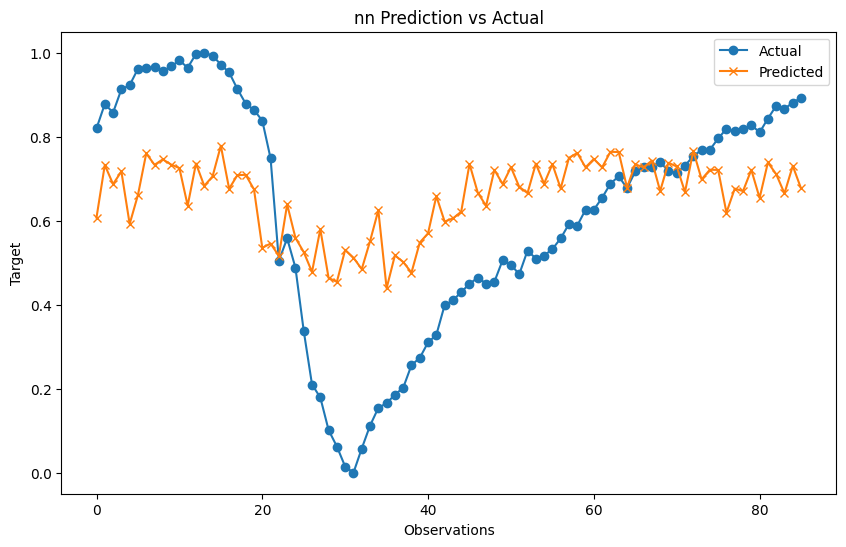

Epoch 1/20
5/5 [==============================] - 1s 60ms/step - loss: 0.1289 - val_loss: 0.0438
Epoch 2/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0593 - val_loss: 0.0643
Epoch 3/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0235 - val_loss: 0.0543
Epoch 4/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0206 - val_loss: 0.0542
Epoch 5/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0131 - val_loss: 0.0464
Epoch 6/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0165 - val_loss: 0.0421
Epoch 7/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0095 - val_loss: 0.0385
Epoch 8/20
5/5 [==============================] - 0s 21ms/step - loss: 0.0144 - val_loss: 0.0377
Epoch 9/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0112 - val_loss: 0.0299
Epoch 10/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0113 - val_loss: 0.0225
Epoch 11/20
5/5 [============

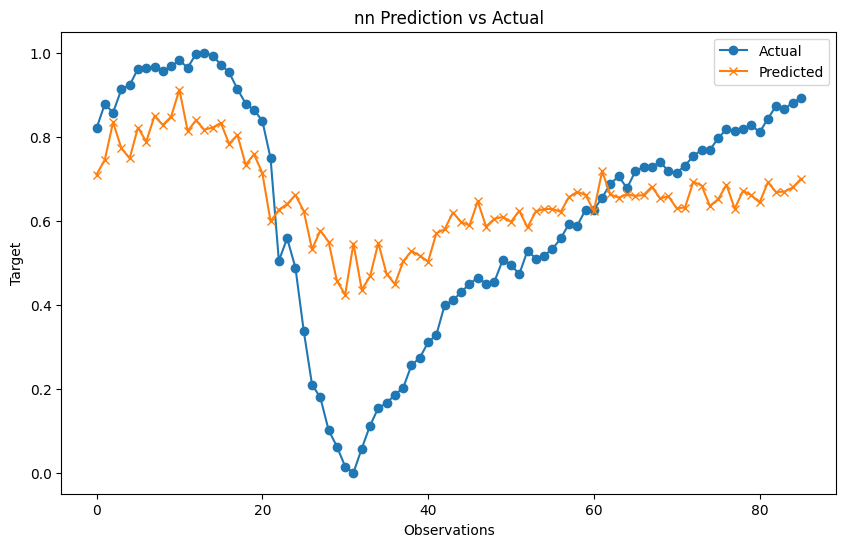

Epoch 1/20
5/5 [==============================] - 1s 72ms/step - loss: 0.1160 - val_loss: 0.0558
Epoch 2/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0540 - val_loss: 0.0068
Epoch 3/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0536 - val_loss: 0.0109
Epoch 4/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0414 - val_loss: 0.0486
Epoch 5/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0317 - val_loss: 0.0247
Epoch 6/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0238 - val_loss: 0.0135
Epoch 7/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0300 - val_loss: 0.0357
Epoch 7: early stopping
3/3 [==============================] - 0s 2ms/step
Mean Squared Error: 0.0593883266492045
3/3 [==============================] - 0s 3ms/step


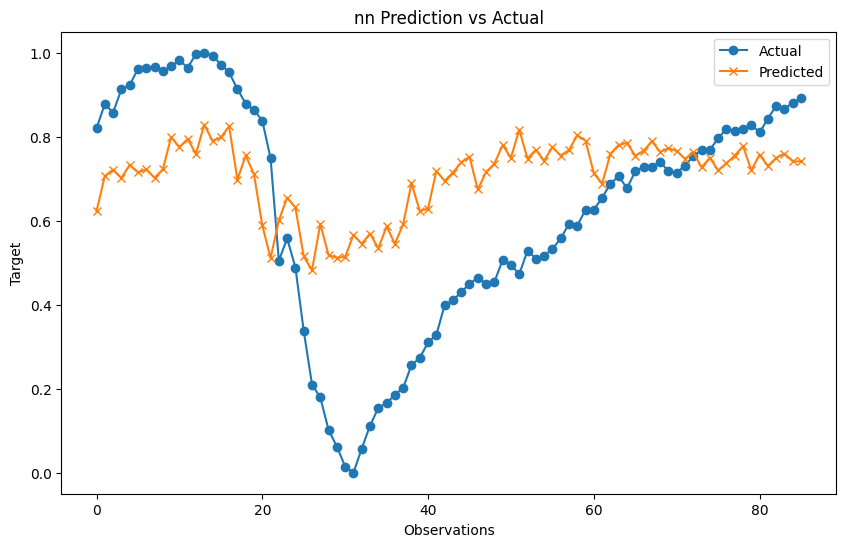

Epoch 1/20
5/5 [==============================] - 1s 67ms/step - loss: 0.2069 - val_loss: 0.0855
Epoch 2/20
5/5 [==============================] - 0s 11ms/step - loss: 0.1042 - val_loss: 0.0992
Epoch 3/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0625 - val_loss: 0.0690
Epoch 4/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0426 - val_loss: 0.0747
Epoch 5/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0648 - val_loss: 0.0644
Epoch 6/20
5/5 [==============================] - 0s 22ms/step - loss: 0.0392 - val_loss: 0.0556
Epoch 7/20
5/5 [==============================] - 0s 21ms/step - loss: 0.0265 - val_loss: 0.0701
Epoch 8/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0282 - val_loss: 0.0525
Epoch 9/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0114 - val_loss: 0.0969
Epoch 10/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0119 - val_loss: 0.0623
Epoch 11/20
5/5 [============

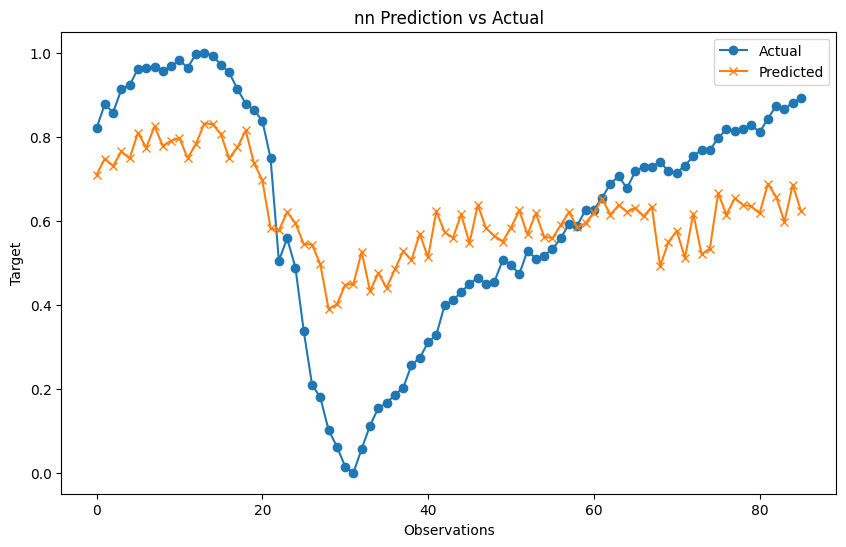

Epoch 1/20
5/5 [==============================] - 1s 52ms/step - loss: 0.1534 - val_loss: 0.0660
Epoch 2/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0724 - val_loss: 0.0878
Epoch 3/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0405 - val_loss: 0.0744
Epoch 4/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0380 - val_loss: 0.0563
Epoch 5/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0300 - val_loss: 0.0369
Epoch 6/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0401 - val_loss: 0.0511
Epoch 7/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0279 - val_loss: 0.0550
Epoch 8/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0233 - val_loss: 0.0526
Epoch 9/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0207 - val_loss: 0.0410
Epoch 10/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0164 - val_loss: 0.0622
Epoch 10: early stopping
3/3 

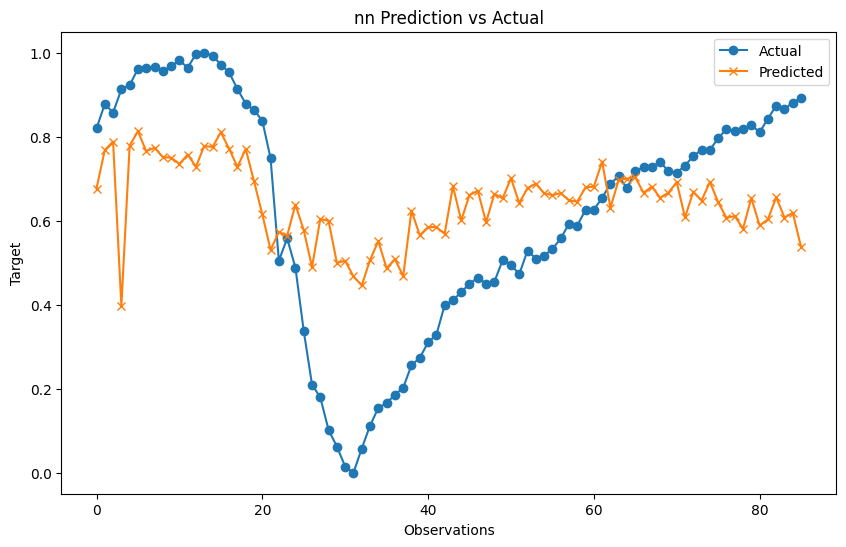

In [130]:

# Early stop mechanism
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,        
    verbose=1,mode='min',   
    restore_best_weights=True  # Restore optimal model weights
)

# Dense model with leave-out verification
for random in randoms:
    tf.random.set_seed(random)
    # Flatten the input data
    # Build a simple fully connected neural network
    nn_model = Sequential([
        Masking(mask_value=0., input_shape=(X_train.shape[1],)),  # Add a Mask Layer
        Dense(128, activation='relu'),  # Hidden layer with 64 units and ReLU activation
        BatchNormalization(),  # Alleviate overfitting
        Dense(32),
        Dense(1,activation='sigmoid')  # Output layer
    ])

    # Compile the model
    nn_model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    history = nn_model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test),callbacks=[early_stopping],verbose=1)
    # Evaluate the model
    y_pred = nn_model.predict(X.reshape(X.shape[0],-1))
    mse = mean_squared_error(y, y_pred)
    print(f"Mean Squared Error: {mse}")
    plot_model(nn_model, "nn",X.reshape(X.shape[0],-1),y)

In [131]:
# Prepare the data needed for cnn training
X_cnn = X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
# leave-out verification
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y, test_size=0.2, random_state=42)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(68, 31, 8, 1) (18, 31, 8, 1)
(68, 1) (18, 1)


Epoch 1/20
5/5 [==============================] - 1s 56ms/step - loss: 0.2059 - val_loss: 0.0627
Epoch 2/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0997 - val_loss: 0.0934
Epoch 3/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0564 - val_loss: 0.0446
Epoch 4/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0696 - val_loss: 0.0381
Epoch 5/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0443 - val_loss: 0.0727
Epoch 6/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0471 - val_loss: 0.0599
Epoch 7/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0314 - val_loss: 0.0339
Epoch 8/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0312 - val_loss: 0.0519
Epoch 9/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0237 - val_loss: 0.0566
Epoch 10/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0180 - val_loss: 0.0341
Epoch 11/20
5/5 [============

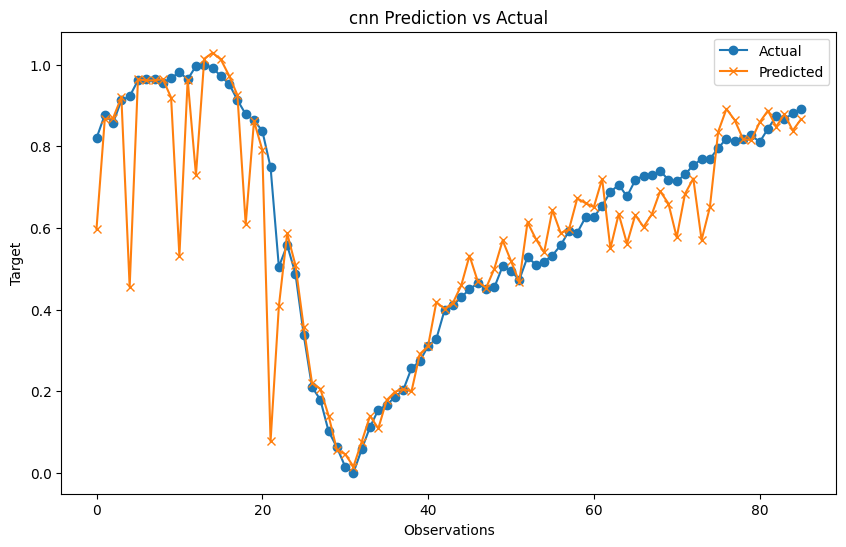

3/3 [==============================] - 0s 3ms/step
Mean Squared Error: 0.015407620275935717
Epoch 1/20
5/5 [==============================] - 1s 47ms/step - loss: 0.2516 - val_loss: 0.0443
Epoch 2/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0886 - val_loss: 0.1048
Epoch 3/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0720 - val_loss: 0.0518
Epoch 4/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0628 - val_loss: 0.0490
Epoch 5/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0504 - val_loss: 0.0713
Epoch 6/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0461 - val_loss: 0.0644
Epoch 7/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0381 - val_loss: 0.0656
Epoch 8/20
5/5 [==============================] - 0s 25ms/step - loss: 0.0330 - val_loss: 0.0601
Epoch 9/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0296 - val_loss: 0.0966
Epoch 10/20
5/5 [==================

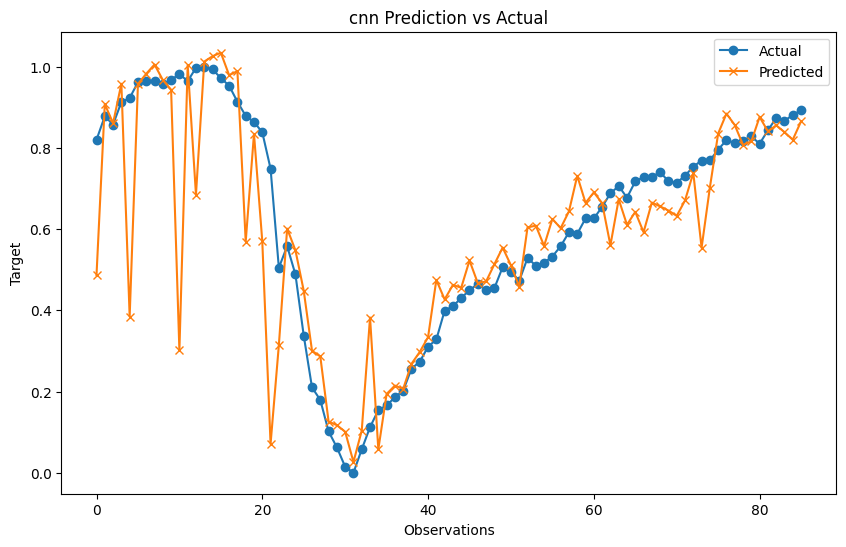

3/3 [==============================] - 0s 3ms/step
Mean Squared Error: 0.023441307304042584
Epoch 1/20
5/5 [==============================] - 1s 50ms/step - loss: 0.2846 - val_loss: 0.0625
Epoch 2/20
5/5 [==============================] - 0s 19ms/step - loss: 0.0822 - val_loss: 0.1007
Epoch 3/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0739 - val_loss: 0.0539
Epoch 4/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0743 - val_loss: 0.0460
Epoch 5/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0543 - val_loss: 0.0664
Epoch 6/20
5/5 [==============================] - 0s 19ms/step - loss: 0.0442 - val_loss: 0.0392
Epoch 7/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0360 - val_loss: 0.0414
Epoch 8/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0278 - val_loss: 0.0613
Epoch 9/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0254 - val_loss: 0.0389
Epoch 10/20
5/5 [==================

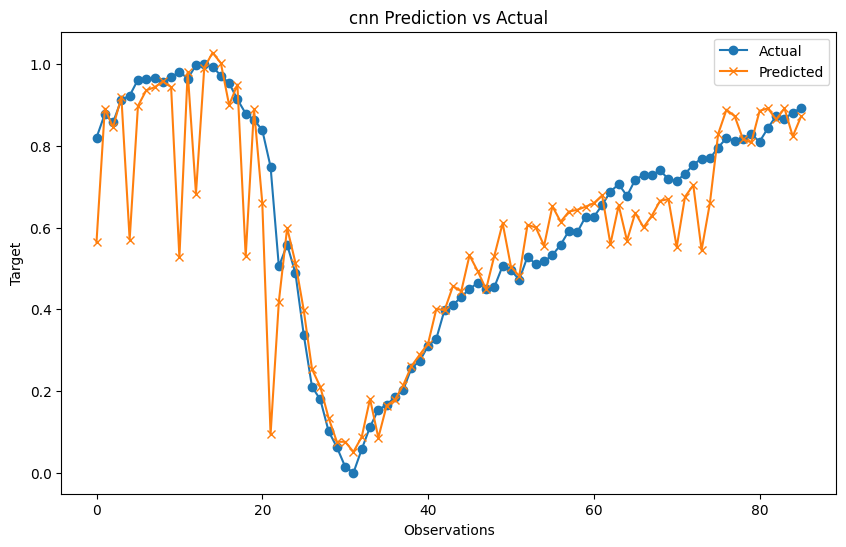

3/3 [==============================] - 0s 4ms/step
Mean Squared Error: 0.016128857637089516
Epoch 1/20
5/5 [==============================] - 1s 49ms/step - loss: 0.1606 - val_loss: 0.0575
Epoch 2/20
5/5 [==============================] - 0s 18ms/step - loss: 0.0678 - val_loss: 0.0503
Epoch 3/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0512 - val_loss: 0.0526
Epoch 4/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0412 - val_loss: 0.0537
Epoch 5/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0308 - val_loss: 0.0389
Epoch 6/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0257 - val_loss: 0.0515
Epoch 7/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0214 - val_loss: 0.0405
Epoch 8/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0188 - val_loss: 0.0467
Epoch 9/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0168 - val_loss: 0.0391
Epoch 10/20
5/5 [==================

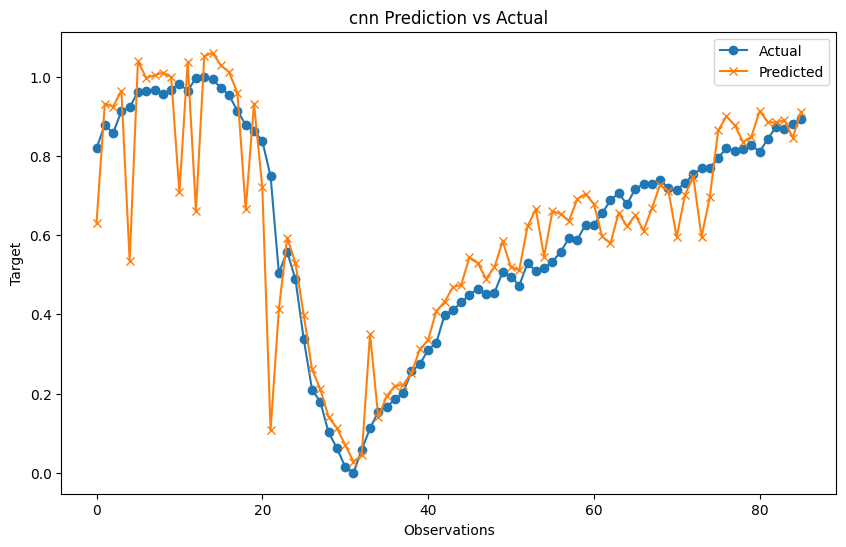

3/3 [==============================] - 0s 3ms/step
Mean Squared Error: 0.014250305500801648
Epoch 1/20
5/5 [==============================] - 1s 46ms/step - loss: 0.2216 - val_loss: 0.0660
Epoch 2/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0918 - val_loss: 0.0498
Epoch 3/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0722 - val_loss: 0.0366
Epoch 4/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0533 - val_loss: 0.0757
Epoch 5/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0499 - val_loss: 0.0362
Epoch 6/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0364 - val_loss: 0.0656
Epoch 7/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0299 - val_loss: 0.0454
Epoch 8/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0250 - val_loss: 0.0527
Epoch 9/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0221 - val_loss: 0.0555
Epoch 10/20
5/5 [==================

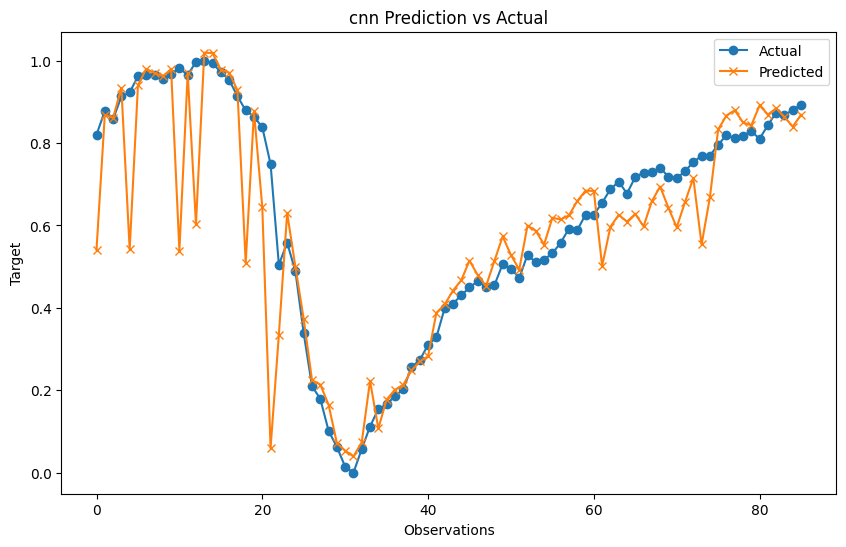

3/3 [==============================] - 0s 3ms/step
Mean Squared Error: 0.01767527505535849


In [132]:
# CNN model
for random in randoms:
    tf.random.set_seed(random)
    cnn_model = Sequential([
        Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
        Conv2D(filters=32, kernel_size=(7, 1), activation='relu'),
        MaxPooling2D(pool_size=2),
        # Conv2D(filters=16, kernel_size=(15, 1), activation='relu'),
        # MaxPooling2D(pool_size=(2,1)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='linear')
    ])

    cnn_model.compile(optimizer='adam', loss='mean_squared_error')

    # Training Model
    history = cnn_model.fit(
        X_train, y_train,
        epochs=20, batch_size=16, 
        validation_data=(X_test, y_test),
        # callbacks=[early_stopping]
        )
    plot_model(cnn_model, "cnn", X, y)

    y_pred = cnn_model.predict(X_cnn)
    mse = mean_squared_error(y, y_pred)
    print(f"Mean Squared Error: {mse}")
    # plt_history(history)

In [133]:
cnn_model.save('./cnn_INDPRO.h5')

c:\Users\15163\.conda\envs\FDH\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
from sklearn.model_selection import TimeSeriesSplit
# Create an instance of TimeSeriesSplit to see the contents of the timing-cross validation
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    # Print these indexes
    print("TRAIN:", train_index, "TEST:", test_index)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] TEST: [15 16 17 18 19 20 21 22 23 24 25 26 27 28]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28] TEST: [29 30 31 32 33 34 35 36 37 38 39 40 41 42]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42] TEST: [43 44 45 46 47 48 49 50 51 52 53 54 55 56]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56] TEST: [57 58 59 60 61 62 63 64 65 66 67 68 69 70]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70] TEST: [71 72 73 74 75 76 77 78 79 80 81 82 83 84]


In [125]:
from sklearn.metrics import mean_squared_error
# Rolling training of CNN
cnn_model = Sequential([
    Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
    Conv2D(filters=32, kernel_size=(12, 1), activation='relu'),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')
    ])
cnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Define scrolling window size
window_size = 9

# historical data
# X_cnn
# y

# Store performance metrics
mse_scores = []
# Scroll Window Iteration
for i in range(len(X_cnn) - window_size):
    # Defining the Scroll Window
    X_train = X_cnn[i:i+window_size]
    X_test  = X_cnn[i+window_size:i+window_size+1]
    y_train = y[i:i+window_size]
    y_test  = y[i+window_size:i+window_size+1]
    
    # training model
    cnn_model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

    # prediction
    y_pred = cnn_model.predict(X_test)
    # Calculate the mean square error
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

# Output performance indicators
print("Mean MSE:", np.mean(mse_scores))

Epoch 1/20
1/1 [==============================] - 1s 971ms/step - loss: 0.8684 - val_loss: 0.7232
Epoch 2/20
1/1 [==============================] - 0s 58ms/step - loss: 0.4785 - val_loss: 0.2339
Epoch 3/20
1/1 [==============================] - 0s 61ms/step - loss: 0.0924 - val_loss: 0.0293
Epoch 4/20
1/1 [==============================] - 0s 44ms/step - loss: 0.0289 - val_loss: 0.0046
Epoch 5/20
1/1 [==============================] - 0s 45ms/step - loss: 0.0686 - val_loss: 0.0026
Epoch 6/20
1/1 [==============================] - 0s 54ms/step - loss: 0.0764 - val_loss: 0.0070
Epoch 7/20
1/1 [==============================] - 0s 49ms/step - loss: 0.0534 - val_loss: 0.0211
Epoch 8/20
1/1 [==============================] - 0s 52ms/step - loss: 0.0260 - val_loss: 0.0463
Epoch 9/20
1/1 [==============================] - 0s 54ms/step - loss: 0.0148 - val_loss: 0.0784
Epoch 10/20
1/1 [==============================] - 0s 53ms/step - loss: 0.0218 - val_loss: 0.1016
Epoch 11/20
1/1 [===========

(15, 31, 8, 1)


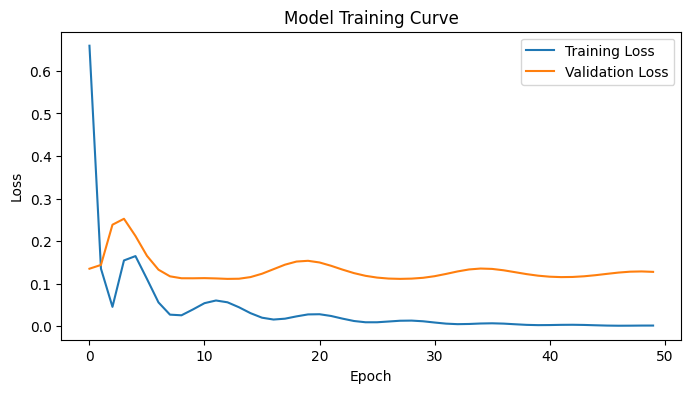

3/3 [==============================] - 0s 3ms/step


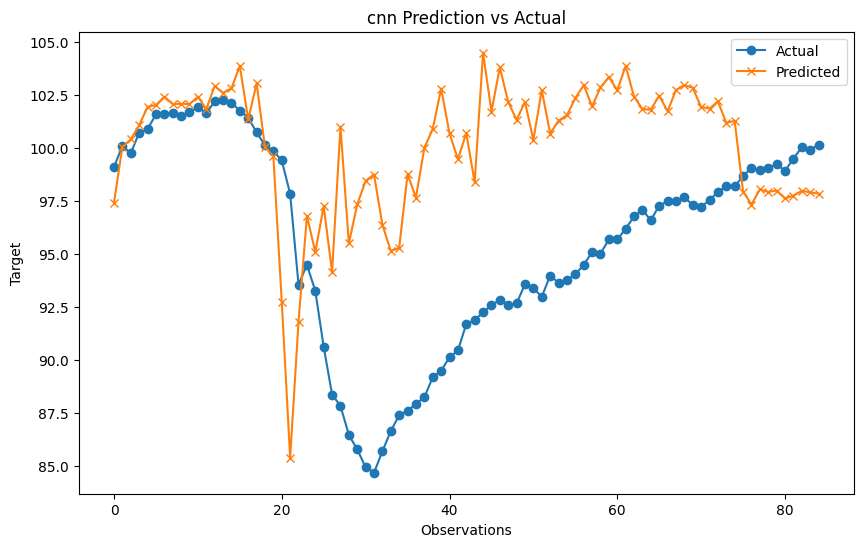

1/1 [==============================] - 0s 30ms/step - loss: 0.1280
Test loss: 0.12799611687660217
1/1 [==============================] - 0s 118ms/step
(29, 31, 8, 1)


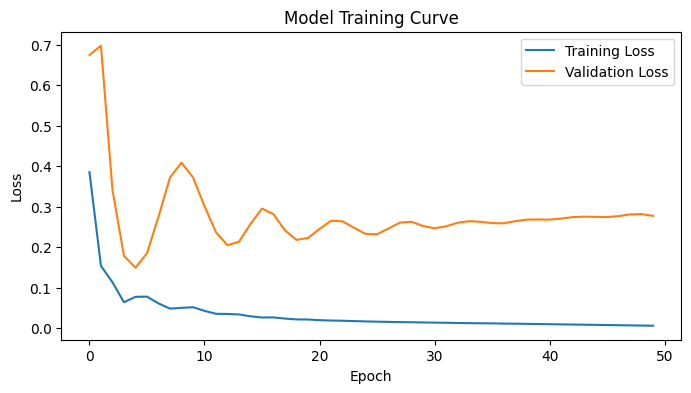

3/3 [==============================] - 0s 2ms/step


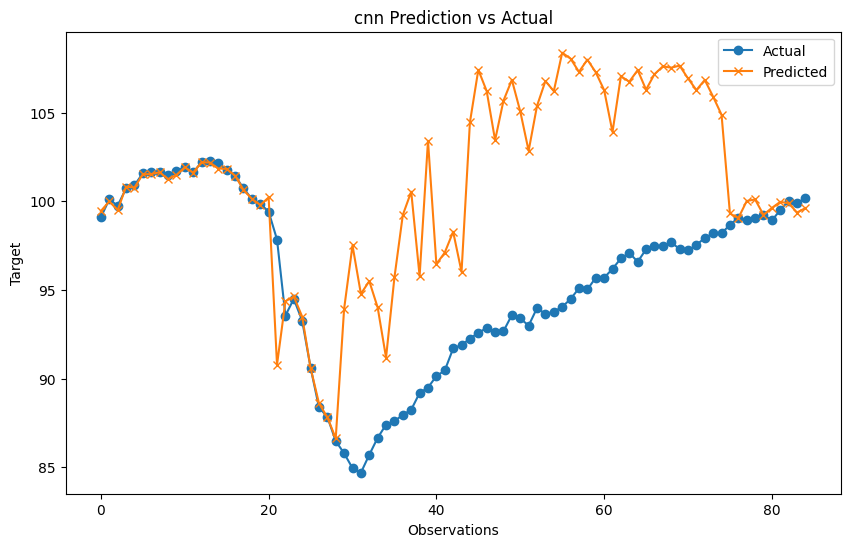

1/1 [==============================] - 0s 31ms/step - loss: 0.2775
Test loss: 0.2775276005268097
1/1 [==============================] - 0s 106ms/step
(43, 31, 8, 1)


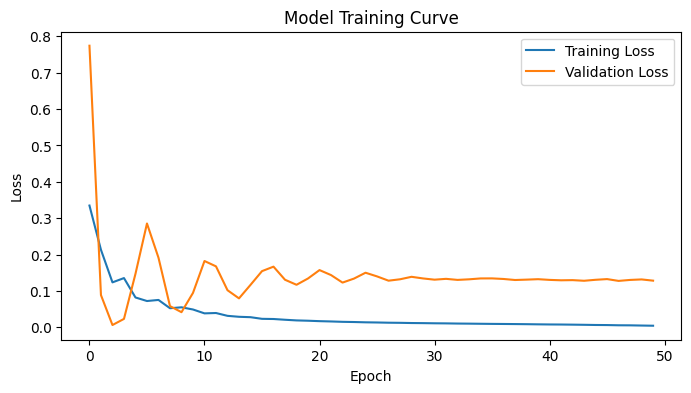

3/3 [==============================] - 0s 2ms/step


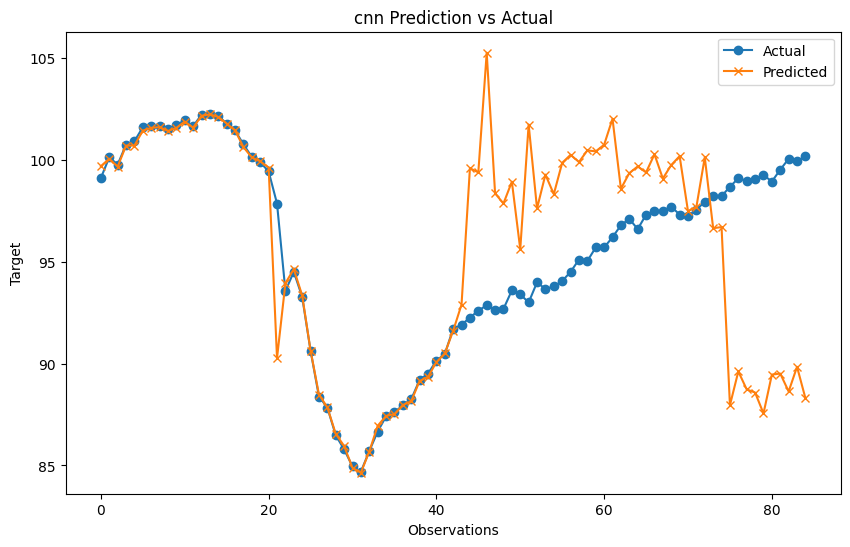

1/1 [==============================] - 0s 31ms/step - loss: 0.1284
Test loss: 0.12843121588230133
1/1 [==============================] - 0s 87ms/step
(57, 31, 8, 1)


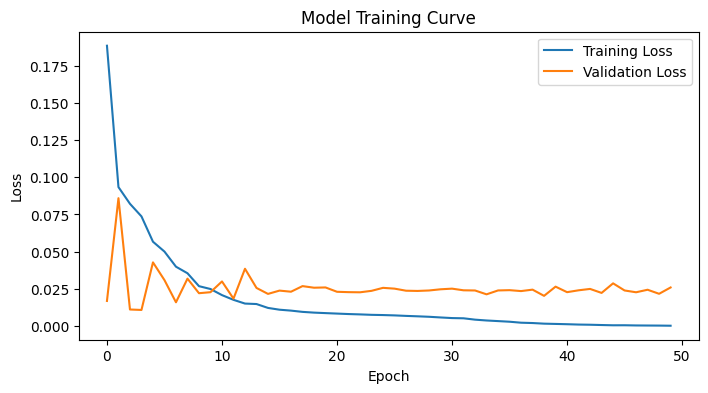

3/3 [==============================] - 0s 3ms/step


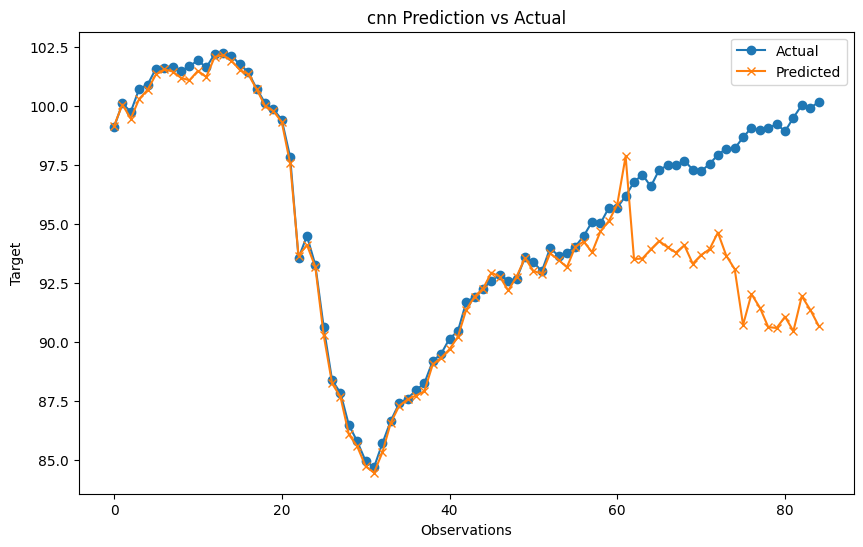

1/1 [==============================] - 0s 39ms/step - loss: 0.0258
Test loss: 0.02584194764494896
1/1 [==============================] - 0s 101ms/step
(71, 31, 8, 1)


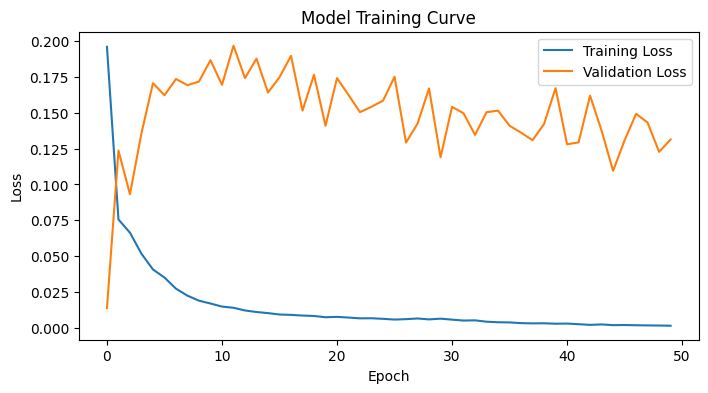

3/3 [==============================] - 0s 3ms/step


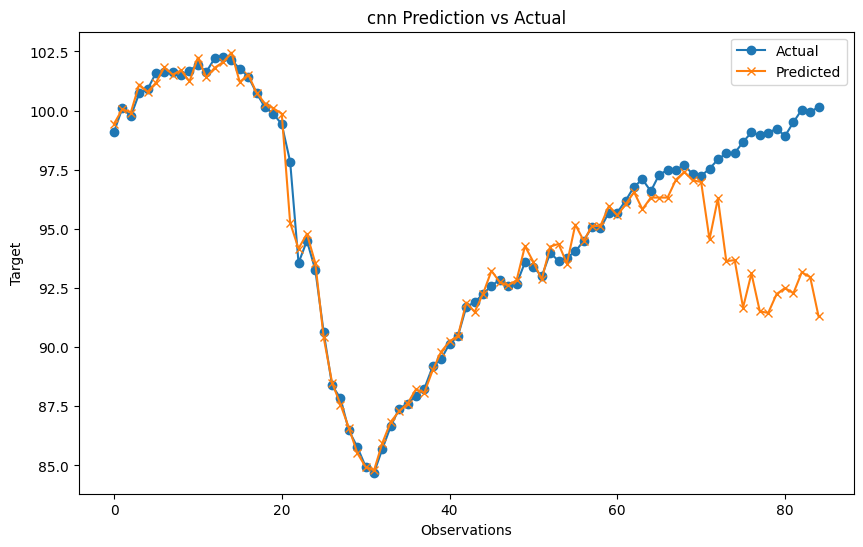

1/1 [==============================] - 0s 62ms/step - loss: 0.1314
Test loss: 0.13135583698749542
1/1 [==============================] - 0s 105ms/step


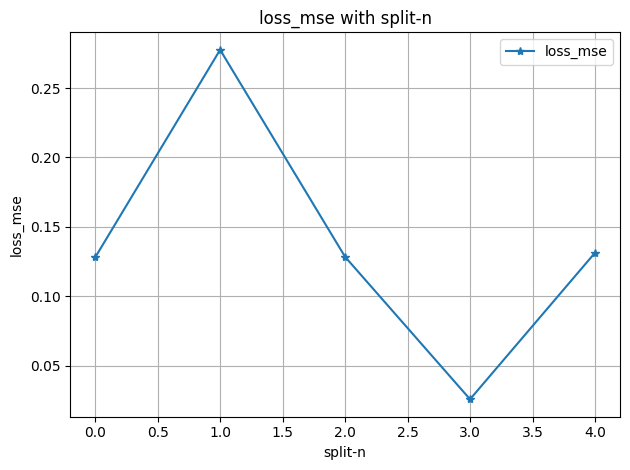

CPU times: total: 28.1 s
Wall time: 23.6 s


In [27]:
%%time
# Time series cross-validation * CNN
tscv = TimeSeriesSplit(n_splits=5) 

# Store the true and predicted values for each prediction
true_values = []
predictions = []
loss_mse = []
# Split datas
for train_index, test_index in tscv.split(X_cnn):
    X_train, X_test = X_cnn[train_index], X_cnn[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(X_train.shape)
    # CNN model
    cnn_model = Sequential([
    Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
    Conv2D(filters=32, kernel_size=(12, 1), activation='relu'),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')
    ])
    # compile the model
    cnn_model.compile(optimizer='adam', loss='mean_squared_error')
    # train the model
    history = cnn_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test),verbose=0)
    plt_history(history)
    # Plotting the predicted values of the present fold model
    plot_model(cnn_model, "cnn", X, y,scaler=scaler)
    # Evaluation
    loss = cnn_model.evaluate(X_test, y_test)
    loss_mse.append(loss)
    print(f"Test loss: {loss}")
    y_pred = cnn_model.predict(X_test)
    # Store the predicted and true values
    predictions.extend(y_pred)
    true_values.extend(y_test)

plt.plot(range(len(loss_mse)), loss_mse, label='loss_mse', marker='*', linestyle='-')
plt.xlabel('split-n')
plt.ylabel('loss_mse')
plt.title('loss_mse with split-n')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

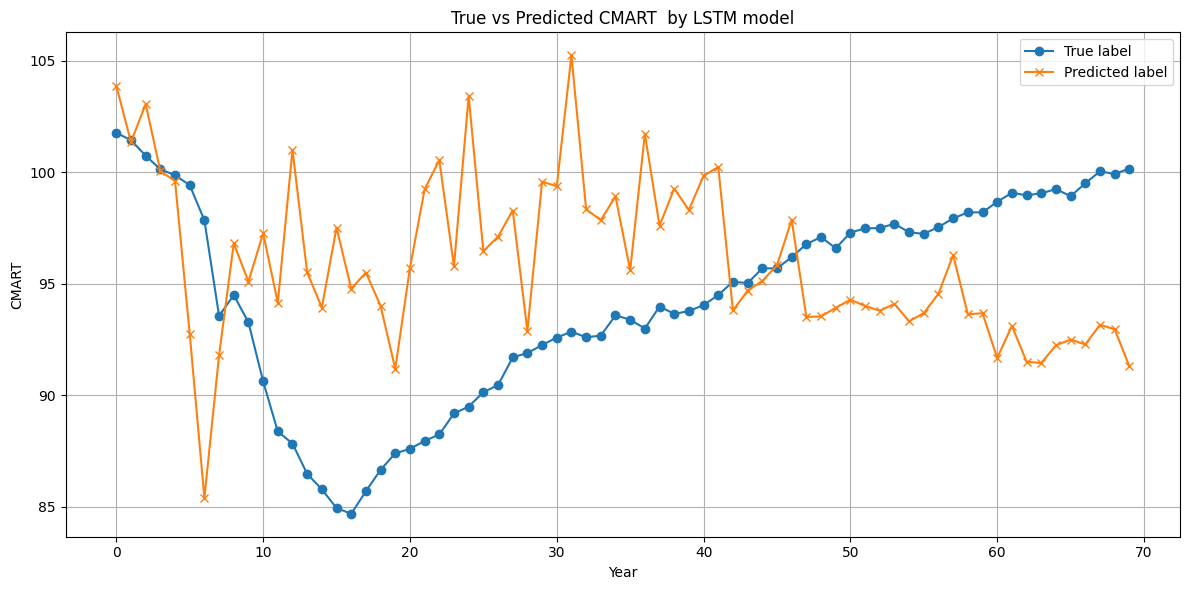

In [29]:
# Use an inverse transformation to bring it back to its original scale
predicted_original = scaler.inverse_transform(predictions)
true_original = scaler.inverse_transform(true_values)
# for i in range(len(predictions)):
#     if predictions[i] < 0:
#         predictions[i] = 0
plt.figure(figsize=(12, 6))
years = range(len(predictions))  # Ensure year range is correct

plt.plot(years, true_original, label='True label', marker='o', linestyle='-')
plt.plot(years, predicted_original, label='Predicted label', marker='x', linestyle='-')
plt.xlabel('Year')
plt.ylabel('CMART')
plt.title('True vs Predicted CMART  by LSTM model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()